# Interoperability with `scirpy`

It is now possible to convert the file formats between `dandelion>=0.1.1` and `scirpy>=0.6.2` [[Sturm2020]](https://academic.oup.com/bioinformatics/article/36/18/4817/5866543) to enhance the collaboration between the analysis toolkits.

We will download the *airr_rearrangement.tsv* file from here:
```bash
# bash
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_b_airr_rearrangement.tsv
```

Gene expression data can also be obtained here

```bash
# bash 
wget https://cf.10xgenomics.com/samples/cell-vdj/4.0.0/sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5
```


<b>Import dandelion module</b>

In [1]:
# import sys
# sys.path.append("C://Users//Amos Choo//Desktop//dandelion")
import os

import dandelion as ddl


# change directory to somewhere more workable

os.chdir(os.path.expanduser("~/Downloads/dandelion_tutorial/"))

ddl.logging.print_versions()

dandelion==0.4.1.dev12 pandas==2.2.3 numpy==2.0.2 matplotlib==3.8.4 networkx==3.4.2 scipy==1.14.1


In [2]:
import scirpy as ir
import scanpy as sc


ir.__version__

'0.13.2.dev3+g7d94860.d20240909'

## `dandelion`

In [3]:
# read in the airr_rearrangement.tsv file
file_location = (
    "sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_t_airr_rearrangement.tsv"
)

# read in gene expression data
adata = sc.read_10x_h5(
    "sc5p_v2_hs_PBMC_10k/sc5p_v2_hs_PBMC_10k_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()

vdj = ddl.read_10x_airr(file_location)
vdj

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Dandelion class object with n_obs = 5351 and n_contigs = 10860
    data: 'cell_id', 'sequence_id', 'sequence', 'sequence_aa', 'productive', 'rev_comp', 'v_call', 'v_cigar', 'd_call', 'd_cigar', 'j_call', 'j_cigar', 'c_call', 'c_cigar', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'junction_length', 'junction_aa_length', 'v_sequence_start', 'v_sequence_end', 'd_sequence_start', 'd_sequence_end', 'j_sequence_start', 'j_sequence_end', 'c_sequence_start', 'c_sequence_end', 'consensus_count', 'umi_count', 'is_cell', 'locus', 'rearrangement_status'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', '

The test file contains a blank `clone_id` column so we run `find_clones` to populate it first.

In [4]:
ddl.tl.find_clones(vdj)

Finding clones based on abT cell VJ chains : 100%|██████████| 1574/1574 [00:00<00:00, 14797.84it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 5351/5351 [00:00<00:00, 590950.81it/s]


### `ddl.to_scirpy` : Converting `dandelion` to `scirpy`

In [5]:
irdata = ddl.to_scirpy(vdj)
irdata

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/utils.py:346: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Us

MuData object with n_obs × n_vars = 5351 × 0
  1 modality
    airr:	5351 x 0
      obsm:	'airr'

Conversion to `AnndData` in scirpy format is also available

In [6]:
mudata = ddl.to_scirpy(vdj, to_mudata=False)
mudata

AnnData object with n_obs × n_vars = 5351 × 0
    obsm: 'airr'

If you have gene expression data, the parameter `gex_adata` supports the gene expression data in `AnnData` format.

Please note that this will slice to the same cell_id that are present in the same in the AIRR data.

In [7]:
irdata = ddl.to_scirpy(vdj, to_mudata=False, gex_adata=adata)
irdata

AnnData object with n_obs × n_vars = 5333 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    obsm: 'airr'

In [8]:
mudata = ddl.to_scirpy(vdj, to_mudata=True, gex_adata=adata)
mudata

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


MuData object with n_obs × n_vars = 10571 × 36601
  2 modalities
    gex:	10553 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    airr:	5351 x 0
      obsm:	'airr'

Use scirpy's get functions to retrieve the relevant airr info (https://scirpy.scverse.org/en/latest/generated/scirpy.get.airr.html)

In [9]:
ir.get.airr(irdata, "clone_id")

,VJ_1_clone_id,VDJ_1_clone_id,VJ_2_clone_id,VDJ_2_clone_id
AAACCTGAGCGATAGC-1,abT_VDJ_20_5_5_VJ_538_2_1,abT_VDJ_20_5_5_VJ_538_2_1,None,None
AAACCTGAGTCACGCC-1,abT_VDJ_228_5_1_VJ_267_1_1,abT_VDJ_228_5_1_VJ_267_1_1,None,None
AAACCTGCACGTCAGC-1,abT_VDJ_228_2_4_VJ_880_2_8,abT_VDJ_228_2_4_VJ_880_2_8,None,None
AAACCTGGTCAATACC-1,abT_VDJ_461_4_3_VJ_45_2_1,abT_VDJ_461_4_3_VJ_45_2_1,None,None
AAACCTGGTTCGGCAC-1,abT_VDJ_309_4_12_VJ_1513_2_1|abT_VDJ_309_4_12_...,abT_VDJ_309_4_12_VJ_1513_2_1|abT_VDJ_309_4_12_...,abT_VDJ_309_4_12_VJ_1513_2_1|abT_VDJ_309_4_12_...,None
...,...,...,...,...
TTTGTCATCGCCGTGA-1,abT_VDJ_274_1_2_VJ_1053_1_1,abT_VDJ_274_1_2_VJ_1053_1_1,None,None
TTTGTCATCGTCTGAA-1,abT_VDJ_276_3_1_VJ_783_2_1,abT_VDJ_276_3_1_VJ_783_2_1,None,None
TTTGTCATCTACCAGA-1,abT_VDJ_189_3_1_VJ_1215_3_1,abT_VDJ_189_3_1_VJ_1215_3_1,None,None
TTTGTCATCTCTGAGA-1,abT_VDJ_459_5_2_VJ_851_1_1|abT_VDJ_150_3_1_VJ_...,abT_VDJ_459_5_2_VJ_851_1_1|abT_VDJ_150_3_1_VJ_...,None,abT_VDJ_459_5_2_VJ_851_1_1|abT_VDJ_150_3_1_VJ_...


In [10]:
ir.get.airr(mudata, "clone_id")

,VJ_1_clone_id,VDJ_1_clone_id,VJ_2_clone_id,VDJ_2_clone_id
cell_id,,,,
AAACCTGAGCGATAGC-1,abT_VDJ_20_5_5_VJ_538_2_1,abT_VDJ_20_5_5_VJ_538_2_1,None,None
AAACCTGAGTCACGCC-1,abT_VDJ_228_5_1_VJ_267_1_1,abT_VDJ_228_5_1_VJ_267_1_1,None,None
AAACCTGCACGTCAGC-1,abT_VDJ_228_2_4_VJ_880_2_8,abT_VDJ_228_2_4_VJ_880_2_8,None,None
AAACCTGGTCAATACC-1,abT_VDJ_461_4_3_VJ_45_2_1,abT_VDJ_461_4_3_VJ_45_2_1,None,None
AAACCTGGTTCGGCAC-1,abT_VDJ_309_4_12_VJ_1513_2_1|abT_VDJ_309_4_12_...,abT_VDJ_309_4_12_VJ_1513_2_1|abT_VDJ_309_4_12_...,abT_VDJ_309_4_12_VJ_1513_2_1|abT_VDJ_309_4_12_...,None
...,...,...,...,...
TTTGTCATCGCCGTGA-1,abT_VDJ_274_1_2_VJ_1053_1_1,abT_VDJ_274_1_2_VJ_1053_1_1,None,None
TTTGTCATCGTCTGAA-1,abT_VDJ_276_3_1_VJ_783_2_1,abT_VDJ_276_3_1_VJ_783_2_1,None,None
TTTGTCATCTACCAGA-1,abT_VDJ_189_3_1_VJ_1215_3_1,abT_VDJ_189_3_1_VJ_1215_3_1,None,None


Or you can add `transfer = True`, which will perform dandelion's `tl.transfer`.

In [11]:
irdatax = ddl.to_scirpy(vdj, transfer=True)
irdatax

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


MuData object with n_obs × n_vars = 5351 × 0
  1 modality
    airr:	5351 x 0
      obs:	'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_abT_VDJ_main', 'j_call_abT_VDJ_main', 'v_call_abT_VJ_main', 'j_call_abT_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
      obsm:	'airr'

In [12]:
irdatax = ddl.to_scirpy(vdj, transfer=True, to_mudata=False)
irdatax

AnnData object with n_obs × n_vars = 5351 × 0
    obs: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ', 'productive_abT_VJ', 'umi_count_abT_VDJ', 'umi_count_abT_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_abT_VDJ_main', 'd_call_abT_VDJ_main', 'j_call_abT_VDJ_main', 'v_call_abT_VJ_main', 'j_call_abT_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_VJ'
    obsm: 'airr'

### `ddl.from_scirpy` : Converting `scirpy` to `dandelion`

Converting `MuData` back to `Dandelion`

In [13]:
vdjx = ddl.from_scirpy(mudata)
vdjx

Dandelion class object with n_obs = 5351 and n_contigs = 10860
    data: 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_call', 'd_cigar', 'd_sequence_end', 'd_sequence_start', 'germline_alignment', 'is_cell', 'j_call', 'j_cigar', 'j_sequence_end', 'j_sequence_start', 'junction', 'junction_aa', 'junction_aa_length', 'junction_length', 'locus', 'productive', 'rearrangement_status', 'rev_comp', 'sequence', 'sequence_aa', 'sequence_alignment', 'sequence_id', 'umi_count', 'v_call', 'v_cigar', 'v_sequence_end', 'v_sequence_start', 'cell_id'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ',

Converting `AnnData` back to `Dandelion`

In [14]:
vdjx = ddl.from_scirpy(irdata)
vdjx

Dandelion class object with n_obs = 5333 and n_contigs = 10836
    data: 'c_call', 'c_cigar', 'c_sequence_end', 'c_sequence_start', 'clone_id', 'consensus_count', 'd_call', 'd_cigar', 'd_sequence_end', 'd_sequence_start', 'germline_alignment', 'is_cell', 'j_call', 'j_cigar', 'j_sequence_end', 'j_sequence_start', 'junction', 'junction_aa', 'junction_aa_length', 'junction_length', 'locus', 'productive', 'rearrangement_status', 'rev_comp', 'sequence', 'sequence_aa', 'sequence_alignment', 'sequence_id', 'umi_count', 'v_call', 'v_cigar', 'v_sequence_end', 'v_sequence_start', 'cell_id'
    metadata: 'clone_id', 'clone_id_by_size', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_abT_VDJ', 'd_call_abT_VDJ', 'j_call_abT_VDJ', 'v_call_abT_VJ', 'j_call_abT_VJ', 'c_call_abT_VDJ', 'c_call_abT_VJ', 'productive_abT_VDJ',

In [15]:
vdjx.metadata

,clone_id,clone_id_by_size,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_VDJ,d_call_VDJ,j_call_VDJ,v_call_VJ,...,d_call_abT_VDJ_main,j_call_abT_VDJ_main,v_call_abT_VJ_main,j_call_abT_VJ_main,isotype,isotype_status,locus_status,chain_status,rearrangement_status_VDJ,rearrangement_status_VJ
AAACCTGAGCGATAGC-1,abT_VDJ_20_5_5_VJ_538_2_1,235,TRB,TRA,True,True,TRBV6-5,None,TRBJ2-3,TRAV23/DV6,...,None,TRBJ2-3,TRAV23/DV6,TRAJ22,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGAGTCACGCC-1,abT_VDJ_228_5_1_VJ_267_1_1,5053,TRB,TRA,True,True,TRBV6-2,None,TRBJ2-6,TRAV8-6,...,None,TRBJ2-6,TRAV8-6,TRAJ8,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGCACGTCAGC-1,abT_VDJ_228_2_4_VJ_880_2_8,4080,TRB,TRA,True,True,TRBV6-2,None,TRBJ2-6,TRAV1-2,...,None,TRBJ2-6,TRAV1-2,TRAJ33,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGGTCAATACC-1,abT_VDJ_461_4_3_VJ_45_2_1,4079,TRB,TRA,True,True,TRBV12-4,None,TRBJ2-7,TRAV22,...,None,TRBJ2-7,TRAV22,TRAJ4,None,None,TRB + TRA,Single pair,standard,standard
AAACCTGGTTCGGCAC-1,abT_VDJ_309_4_12_VJ_1490_2_1|abT_VDJ_309_4_12_...,4077|4078,TRB,TRA|TRA,True,True|True,TRBV20-1,None,TRBJ1-1,TRAV8-3|TRAV8-2,...,None,TRBJ1-1,TRAV8-3,TRAJ21,None,None,TRB + Extra VJ,Extra pair,standard,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGCCGTGA-1,abT_VDJ_274_1_2_VJ_1053_1_1,2061,TRB,TRA,True,True,TRBV12-4,None,TRBJ2-3,TRAV8-2,...,None,TRBJ2-3,TRAV8-2,TRAJ13,None,None,TRB + TRA,Single pair,standard,standard
TTTGTCATCGTCTGAA-1,abT_VDJ_276_3_1_VJ_783_2_1,2060,TRB,TRA,True,True,TRBV7-8,None,TRBJ1-3,TRAV8-6,...,None,TRBJ1-3,TRAV8-6,TRAJ27,None,None,TRB + TRA,Single pair,standard,standard
TTTGTCATCTACCAGA-1,abT_VDJ_189_3_1_VJ_1215_3_1,2059,TRB,TRA,True,True,TRBV6-6,TRBD1,TRBJ2-3,TRAV8-6,...,TRBD1,TRBJ2-3,TRAV8-6,TRAJ48,None,None,TRB + TRA,Single pair,standard,standard
TTTGTCATCTCTGAGA-1,abT_VDJ_150_3_1_VJ_851_1_1|abT_VDJ_459_5_2_VJ_...,2057|2058,TRB|TRB,TRA,True|True,True,TRBV7-2|TRBV11-2,None,TRBJ1-2|TRBJ1-4,TRAV3,...,None,TRBJ1-2,TRAV3,TRAJ22,None|None,Multi,Extra VDJ + TRA,Extra pair,standard,standard


This time, find clones with `scirpy`'s method.

In [16]:
ir.tl.chain_qc(irdata)
ir.pp.ir_dist(irdata)
ir.tl.define_clonotypes(irdata, receptor_arms="all", dual_ir="primary_only")
irdata

AnnData object with n_obs × n_vars = 5333 × 36601
    obs: 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clone_id', 'clone_id_size'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'
    uns: 'chain_indices', 'ir_dist_nt_identity', 'clone_id'
    obsm: 'airr', 'chain_indices'

### Visualising with `scirpy`'s plotting tools

You can now also plot `dandelion` networks using `scirpy`'s functions.

In [17]:
ddl.tl.generate_network(vdj, key="junction")

Setting up data: 10860it [00:00, 20301.12it/s]
Linking edges : 100%|██████████| 5244/5244 [00:00<00:00, 67064.87it/s]


Computing network layout
Computing expanded network layout


In [18]:
irdata.obs["scirpy_clone_id"] = irdata.obs["clone_id"]  # stash it
ddl.tl.transfer(
    irdata, vdj, overwrite=True
)  # overwrite scirpy's clone_id definition

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp


<Axes: >

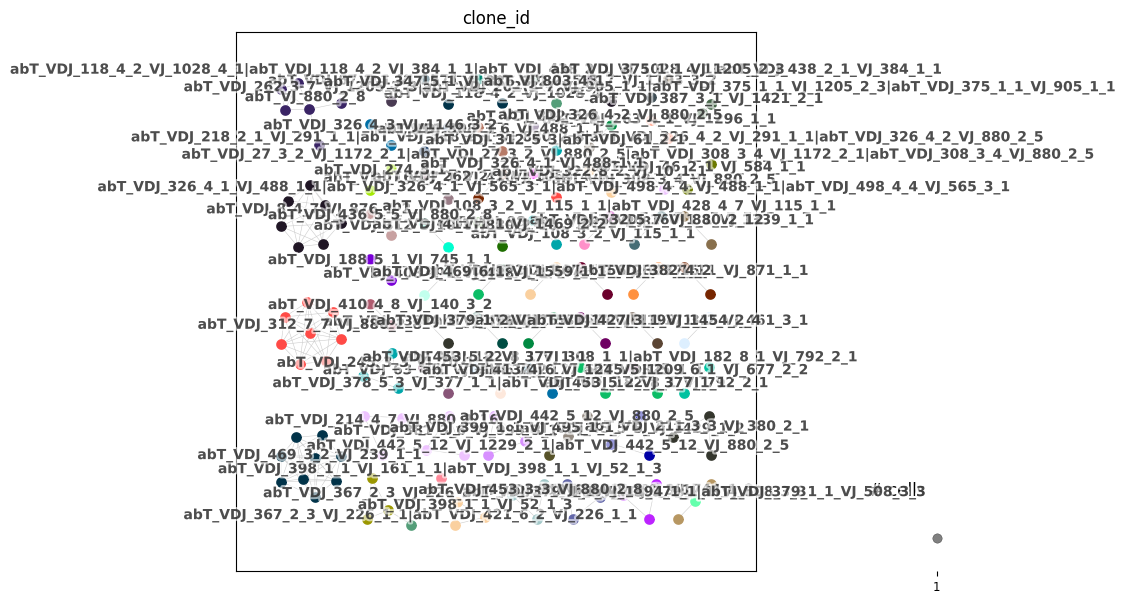

In [19]:
ir.tl.clonotype_network(irdata, min_cells=2)
ir.pl.clonotype_network(irdata, color="clone_id", panel_size=(7, 7))

to swap to a shorter clone_id name (ordered by size)

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp


<Axes: >

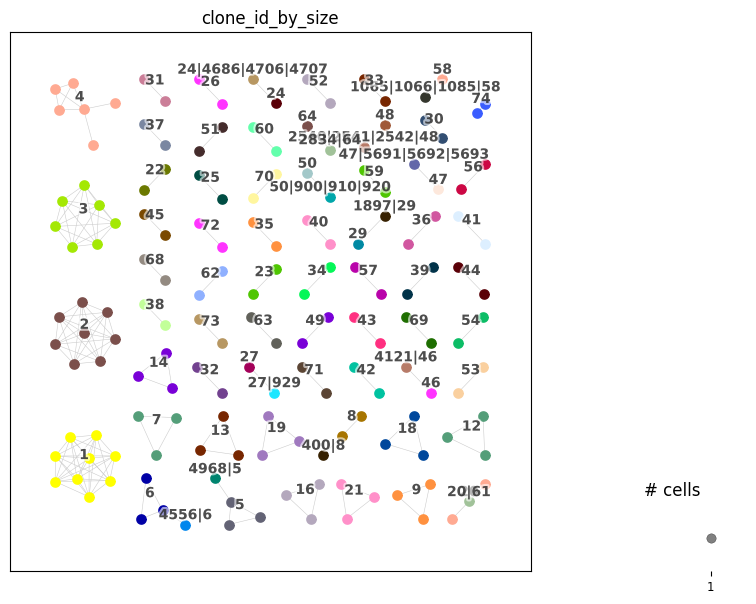

In [20]:
ddl.tl.transfer(irdata, vdj, clone_key="clone_id_by_size")
ir.tl.clonotype_network(irdata, clonotype_key="clone_id_by_size", min_cells=2)
ir.pl.clonotype_network(irdata, color="clone_id_by_size", panel_size=(7, 7))

you can also collapse the networks to a single node and plot by size

/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp


<Axes: >

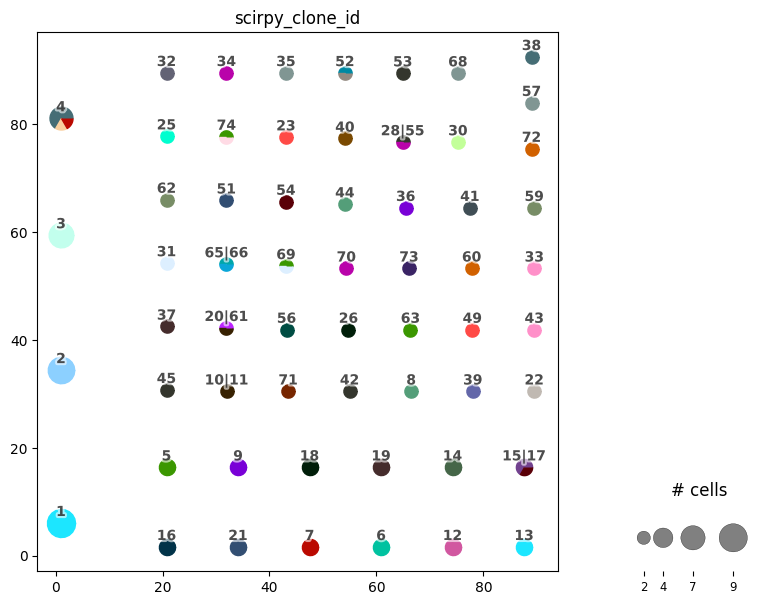

In [21]:
ddl.tl.transfer(irdata, vdj, clone_key="clone_id_by_size", collapse_nodes=True)
ir.tl.clonotype_network(irdata, clonotype_key="clone_id_by_size", min_cells=2)
ir.pl.clonotype_network(irdata, color="scirpy_clone_id", panel_size=(7, 7))